In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt
from data import load_baseball
from utils import despine, ECDF, despine_traceplot

# For deterministic reproducibility.
np.random.seed(42)

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Introduction

Baseball players have many metrics measured for them. Let's say we are on a baseball team, and would like to quantify player performance, one metric being their batting average (defined by how many times a batter hit a pitched ball, divided by the number of times they were up for batting ("at bat")). How would you go about this task?

## Discussion

Discuss with your neighbors the following questions.

1. What data would we need?
1. What metric would you rank by? 
1. Would your metric be reasonable for rookie players?

Let's read in the data.

In [2]:
df = load_baseball()

## Betas, bernoullis and binomials: A brief introduction

- Bernoulli distribution: a probability distribution modelling one "coin flip"-like trial. Parameterized by a single parameter `p`, which indicates probability of "success".
- Binomail distribution: a probability distribution modelling the number of successes in `n` trials. Parameterized by both `n` and `p`.
- Beta distributions: a probability distribution bounded over the interval $(0, 1)$. Models distribution of probability values, usually the `p` in a Bernoulli or Binomial. Parameterized by $\alpha$ and $\beta$, which can be thought of as "number of successes" and "number of failures" respectively.

### Focus on beta

Let's say we wanted to model a probability distribution centered approximately on 0.2. Depending on our parameterization of the Beta distribution, we can express different levels of confidence (as measured by the spread of the distribution) as to how sure we are a distribution takes on that value.

The code + chart below should illustrate this clearly.

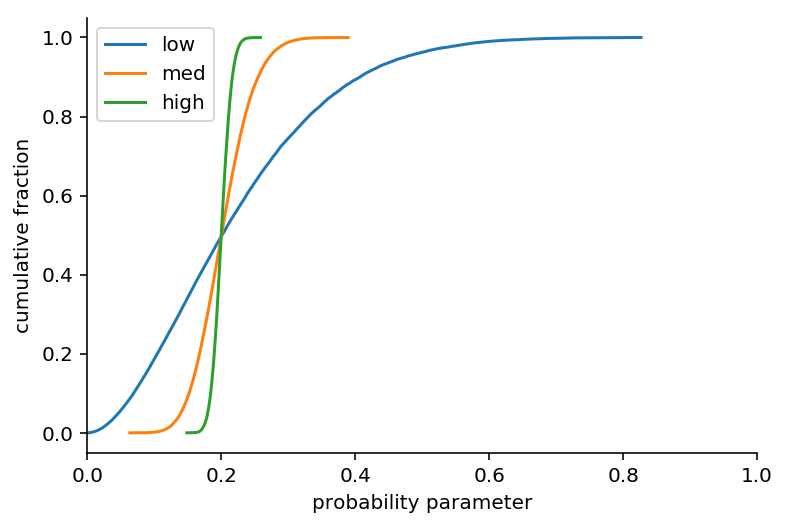

In [3]:
# To correctly express the beta distribution, we subtract 1.
low_prior = np.random.beta(a=1, b=7, size=100000)
med_prior = np.random.beta(a=19, b=79, size=100000)
high_prior = np.random.beta(a=199, b=799, size=100000)

fig = plt.figure()
ax = fig.add_subplot(111)

labels = ['low', 'med', 'high']
priors = [low_prior, med_prior, high_prior]

for label, prior in zip(labels, priors):
    x, y = ECDF(prior)
    ax.plot(x, y, label=label)
ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel('probability parameter')
ax.set_ylabel('cumulative fraction')
despine(ax)

Notice how increasing the scale of parameterization (1x, 10x, 100x) decreased the variance. This leads to another way of looking at the Beta distribution:

- $\alpha$ is the probability of success $p$ multiplied by a scale factor $\kappa$.
- $\beta$ is $1-p$ multiplied by the same scale factor $\kappa$.

We will see this in action below!

### Exercise

Write a naive estimation model for the players above.

In [4]:
with pm.Model() as baseline_model:
    thetas = pm.Beta("thetas", alpha=1, beta=1, shape=(len(df)))
    like = pm.Binomial('likelihood', n=df['AB'], p=thetas, observed=df['H'])

Now, sample from the posterior

In [5]:
with baseline_model:
    baseline_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas_logodds__]
100%|██████████| 2500/2500 [00:04<00:00, 548.76it/s]


Plot the traceplots to check for convergence.

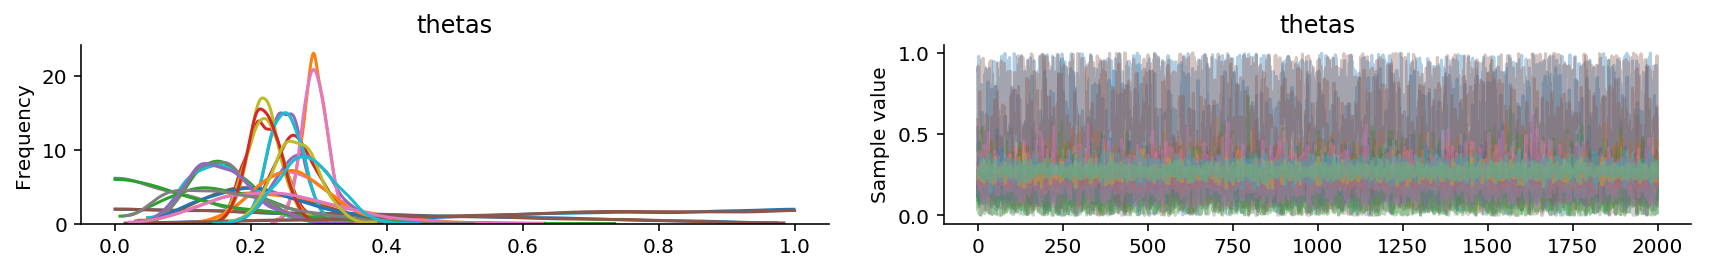

In [6]:
traceplot = pm.traceplot(baseline_trace)
despine_traceplot(traceplot)

Visualize the posterior distribution using forest plots.

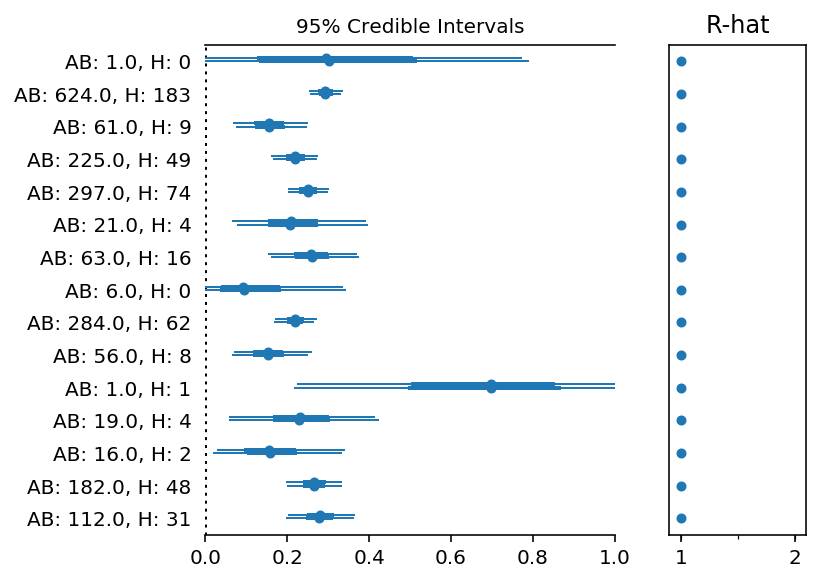

In [7]:
ylabels = ylabels = "AB: " + df['AB'].astype(str) + ', H: ' + df['H'].astype('str')
pm.forestplot(baseline_trace, ylabels=ylabels, xlim=[0, 1])

## Discussion

Are the estimates reasonable, particularly for players that have had only one at bat (AB)?

# Hierarchical Modelling

## Discussion

- How do we deal with the fact that some players have only had 1 at bat (AB = 1), and zero hits (H = 0)? 
- Would it be reasonable, fair, and in line with prior knowledge that the player's true batting average was zero? 

## Assumptions

If it is qualitatively (and maybe also quantitatively) justifiable, we can impose the following assumption on the modelling process.

We can assume that there is some underlying distribution for a player's batting average. We can then assume that each new player draws his own batting average from the underlying distribution. This encodes our intuition that human performance falls on some continuum that has a region of "concentrated" average. (Think "normal-like" distribution.)

The modelling choices for the hierarchical model below are detailed in the [PyMC3 docs](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html), but are copied below for convenience. 

> We will assume that there exists a hidden factor (phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.
> 
> Next, we introduce a hyperparameter kappa to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter, it may also be parametrized in terms of its mean $\mu \in [0, 1]$ and sample size (a proxy for variance) $\nu = \alpha + \beta (\nu > 0)$
>
> The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a Binomial distribution. This is where the data are brought to bear on the model.
> 
> We could use `pm.Pareto('kappa', m=1.5)`, to define our prior on kappa, but the Pareto distribution has very long tails. Exploring these properly is difficult for the sampler, so we use an equivalent but faster parametrization using the exponential distribution. We use the fact that the log of a Pareto distributed random variable follows an exponential distribution.

The most important thing to note is how the ${\theta}$ parameters are drawn from a parental distribution that is not broadcast across the samples.

**Notes:** 

- If you recall the parameterization of the beta distribution described above, it is exactly $p$ and $1-p$ multiplied by a scalar $\kappa$! In the model spec below, we are treating phi and kappa as being parameters to estimate.
- The model below expresses the intuition that the scale parameter is Pareto distributed - the intuition being that approx. 80% of the distribution is going to be small, but 20% of the time it'll be large.

In [8]:
with pm.Model() as baseball_model:
    
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(df))
    like = pm.Binomial('like', n=df['AB'], p=thetas, observed=df['H'])

Sample from the posterior.

In [9]:
with baseball_model:
    trace = pm.sample(2000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas_logodds__, kappa_log_log__, phi_interval__]
100%|██████████| 2500/2500 [00:13<00:00, 186.36it/s]
The number of effective samples is smaller than 25% for some parameters.


Visualize the trace plots to check for convergence.

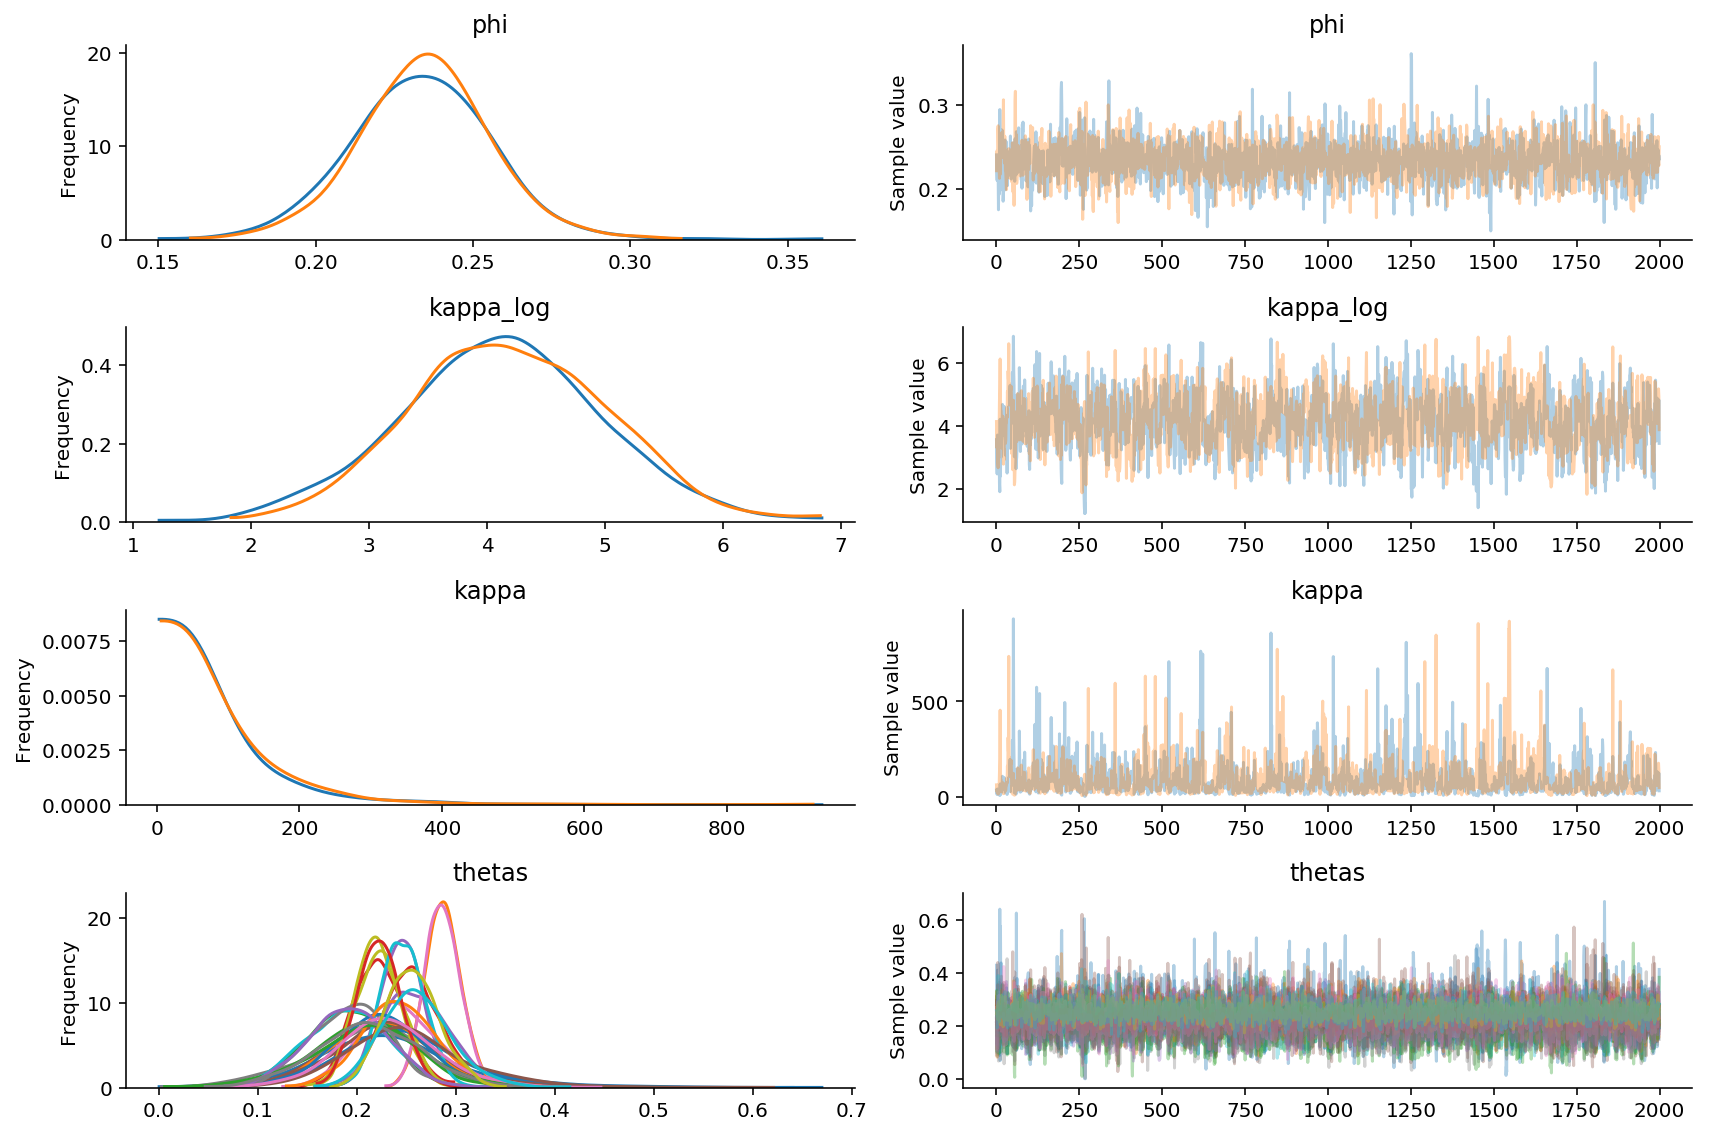

In [10]:
ax_arr = pm.traceplot(trace)
despine_traceplot(ax_arr)

Visualize the posterior distributions using forestplots.

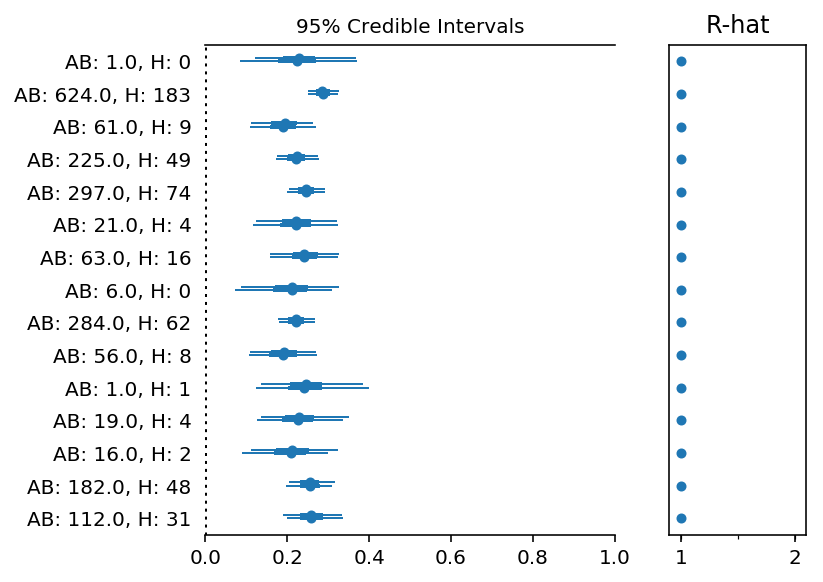

In [11]:
ylabels = "AB: " + df['AB'].astype(str) + ', H: ' + df['H'].astype('str')
pm.forestplot(trace, varnames=['thetas'], ylabels=ylabels, xlim=[0, 1])

With a hierarchical model, we make the assumption that our observations (or treatments that group our observations) are somehow related. Under this assumption, when we have a new sample for which we have very few observations, we are able to borrow power from the population to make inferences about the new sample. 

Depending on the scenario, this assumption can either be reasonable, thereby not necessitating much debate, or be considered a "strong assumption", thereby requiring strong justification. 

## Shrinkage

"Shrinkage" is a term used to describe how hierarchical model estimation will usually result in parameter estimates that are "shrunk" away from their maximum likelihood estimators (i.e. the naive estimate from the data) towards the global mean. 

Shrinkage in and of itself is not necessarily a good or bad thing. However, because hierarchical models can sometimes be tricky to get right, we can use a shrinkage plot as a visual diagnostic for whether we have implemented the model correctly.

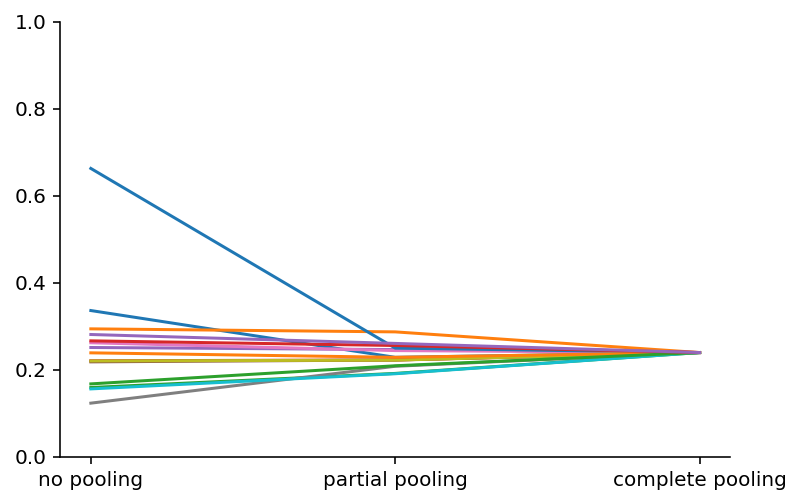

In [12]:
no_pool = baseline_trace['thetas'].mean(axis=0)
partial_pool = trace['thetas'].mean(axis=0)
complete_pool = np.array([df['batting_avg'].mean()] * len(df))

fig = plt.figure()
ax = fig.add_subplot(111)

for r in np.vstack([no_pool, partial_pool, complete_pool]).T:
    ax.plot(r)
    
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['no pooling', 'partial pooling', 'complete pooling'])
ax.set_ylim(0, 1)
despine(ax)

# Summary

- Hierarchical modelling assumes a "hierarchical structure" that governs relatedness between our observed samples.
- Under the assumption of hierarchical structure holding true, we will not get estimates that one may consider to be absurd (e.g. long-run batting probability estimated to be zero or one, on the basis onf few observations).

# Further Exercises

- Change the priors. How do they change the posteriors?
- Change the parameterization of the model. How do they change your inference?

# Credits

## Model Credits

This model implementation is taken from the [PyMC3 docs](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html).

## Data Credits

The data come from the [Baseball Data Bank](https://github.com/chadwickbureau/baseballdatabank), and are redistributed with this repository for educational purposes.